In [12]:
%matplotlib inline
import pandas as pd
import dask.dataframe as dd
import numpy as np
import altair as alt
import seaborn as sns
import math

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn import metrics

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

from sklearn.linear_model import LinearRegression
from sklearn import svm


plt.style.use('ggplot')

In [15]:
# 878049 rows x 9 columns
train = pd.read_csv('crimetrain.csv', parse_dates=['Dates']) #index_col='click_time'
train.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


In [23]:
# no nulls, yay!
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878049 entries, 0 to 878048
Data columns (total 9 columns):
Dates         878049 non-null datetime64[ns]
Category      878049 non-null object
Descript      878049 non-null object
DayOfWeek     878049 non-null object
PdDistrict    878049 non-null object
Resolution    878049 non-null object
Address       878049 non-null object
X             878049 non-null float64
Y             878049 non-null float64
dtypes: datetime64[ns](1), float64(2), object(6)
memory usage: 60.3+ MB


In [19]:
print("Num of Categories: ", train['Category'].nunique())
print("Num of Descripts: ", train['Descript'].nunique())

Num of Categories:  39
Num of Descripts:  879


### Possibly drop Resolution column?
Seems highly unlikely that a crime's resolution will be a great indicator of the type of crime that was committed. 

In [72]:
train.Resolution.unique()

array(['ARREST, BOOKED', 'NONE', 'ARREST, CITED', 'PSYCHOPATHIC CASE',
       'JUVENILE BOOKED', 'UNFOUNDED', 'EXCEPTIONAL CLEARANCE', 'LOCATED',
       'CLEARED-CONTACT JUVENILE FOR MORE INFO', 'NOT PROSECUTED',
       'JUVENILE DIVERTED', 'COMPLAINANT REFUSES TO PROSECUTE',
       'JUVENILE ADMONISHED', 'JUVENILE CITED',
       'DISTRICT ATTORNEY REFUSES TO PROSECUTE',
       'PROSECUTED BY OUTSIDE AGENCY', 'PROSECUTED FOR LESSER OFFENSE'],
      dtype=object)

### Other
TREA = Trespassing or loitering near posted industrial property

# Exploratory Data Analysis

## Group by day of week and category

/usr/local/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


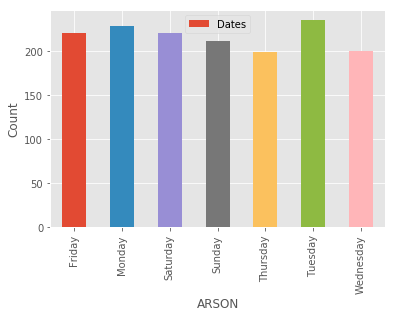

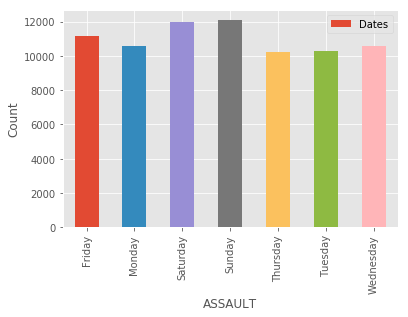

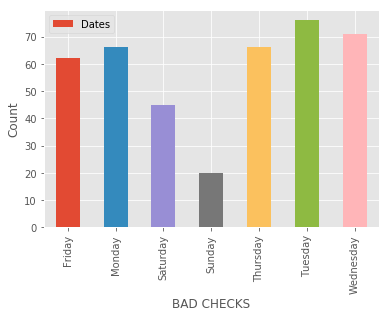

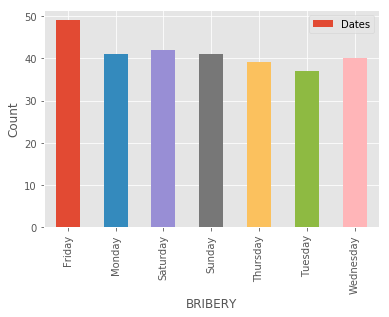

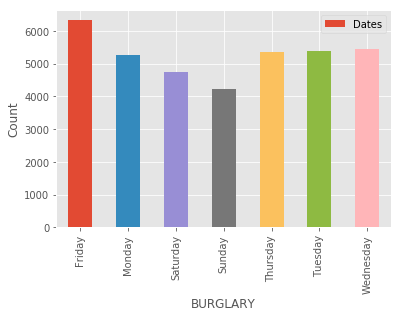

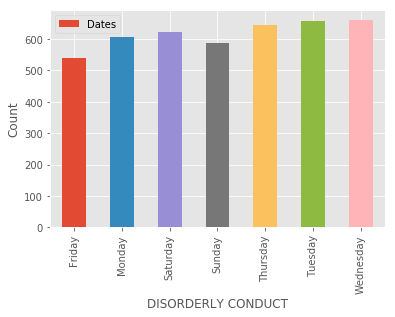

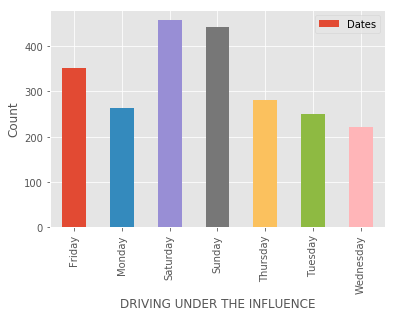

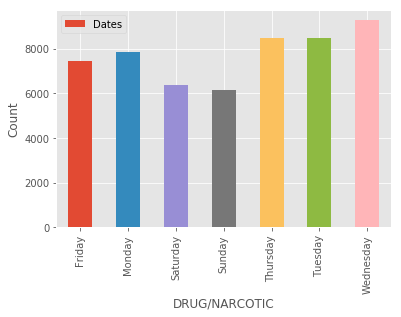

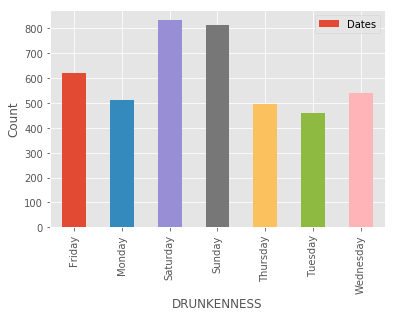

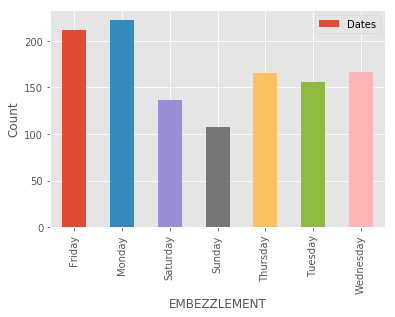

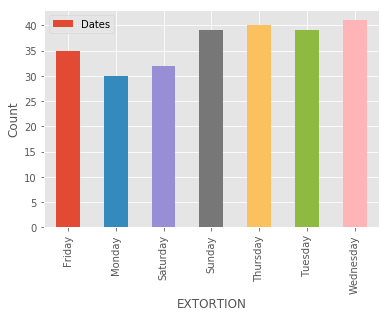

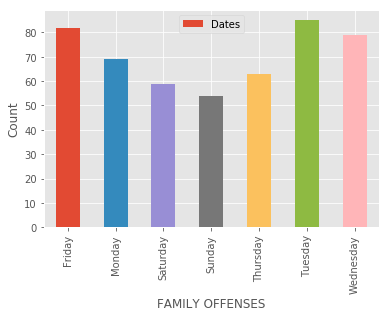

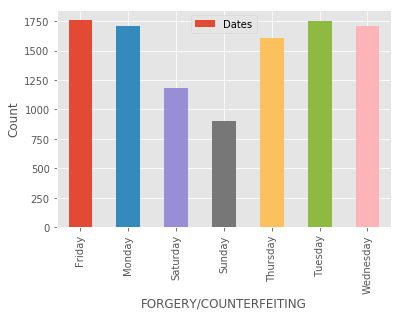

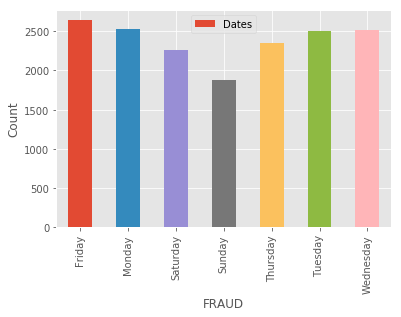

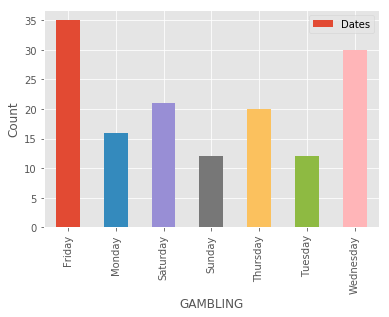

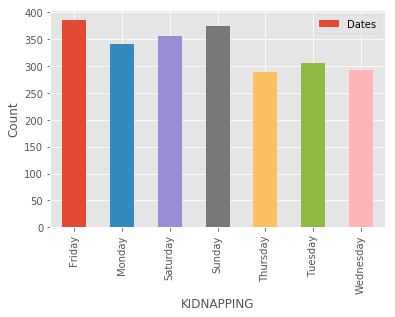

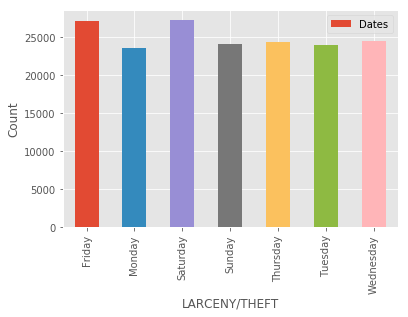

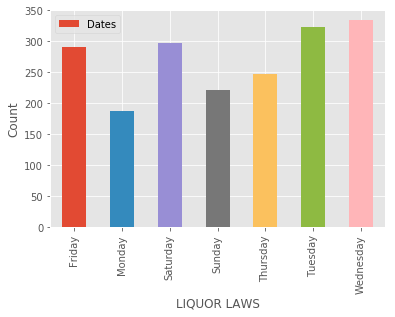

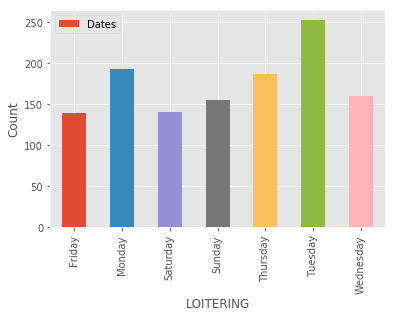

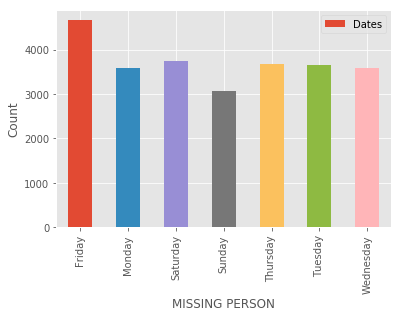

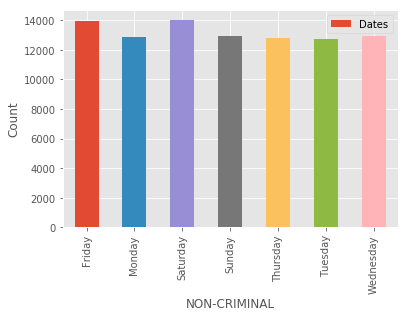

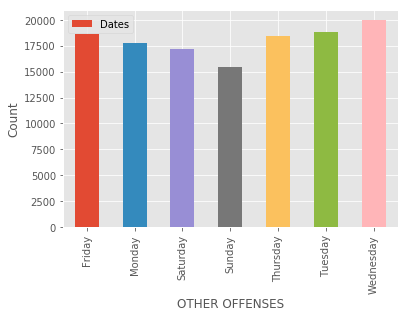

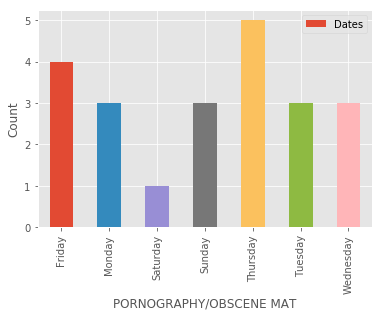

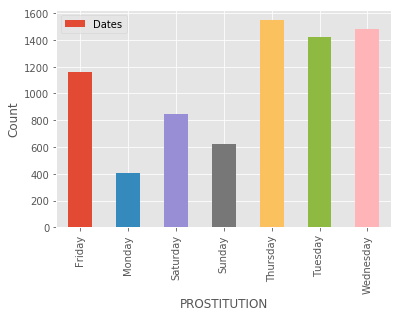

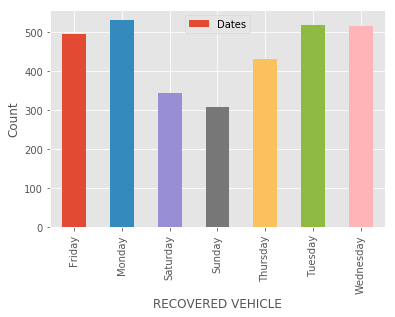

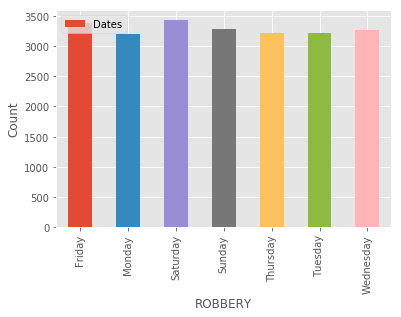

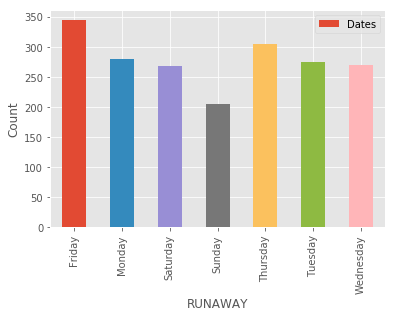

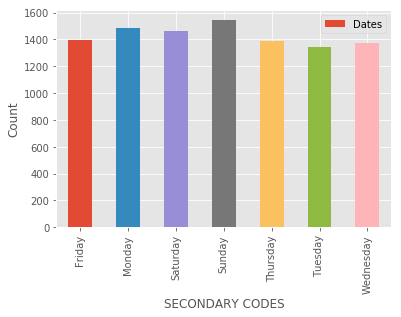

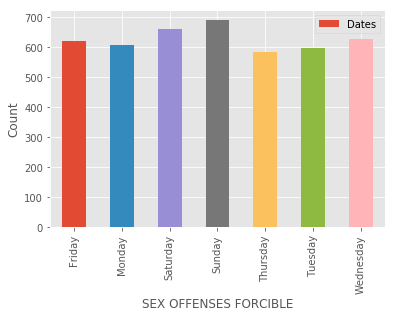

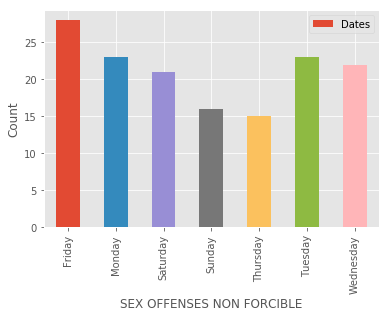

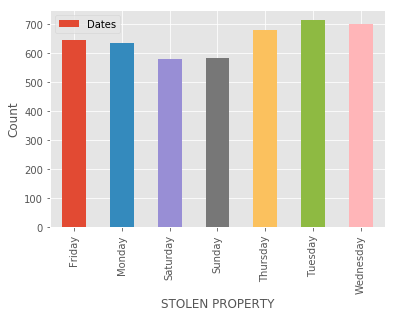

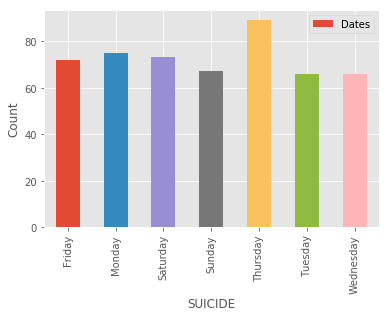

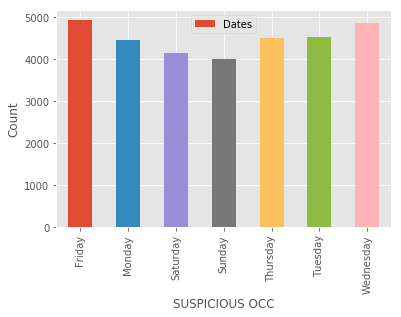

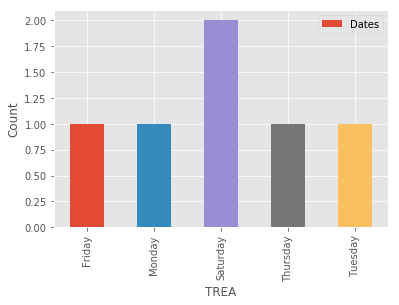

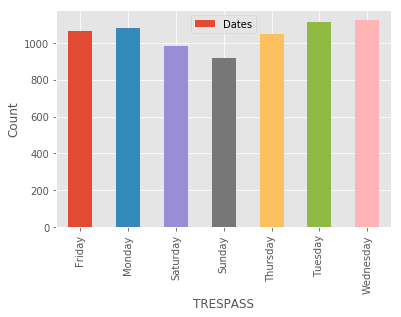

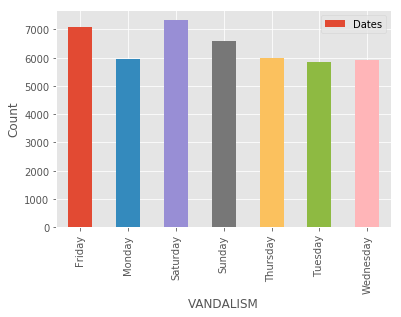

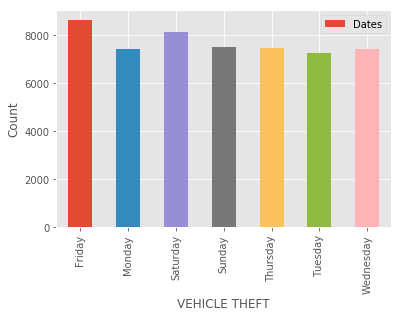

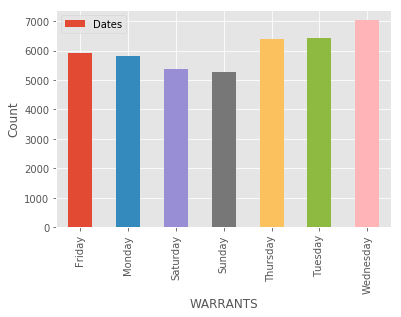

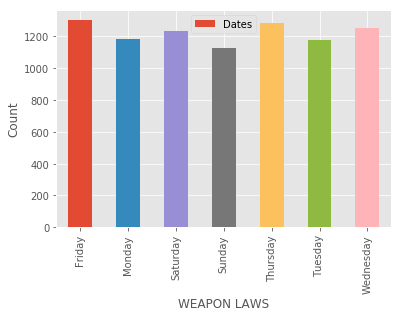

In [10]:
cpddist = train.groupby(['Category', 'DayOfWeek']).count().reset_index()
for category in cpddist['Category'].unique():
    data = cpddist[cpddist['Category'] == category]
    data.plot.bar(x='DayOfWeek', y='Dates')
    plt.xlabel(category)
    plt.ylabel('Count')

### Takeaways

## Group by PdDistrict and category

/usr/local/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


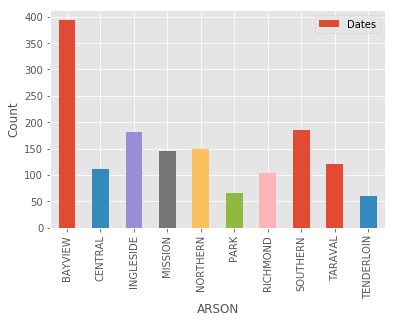

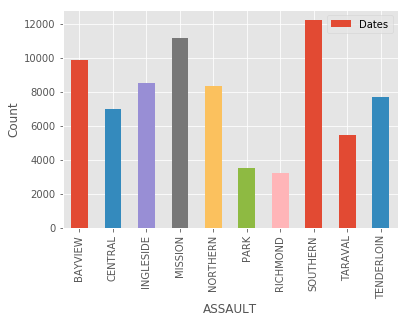

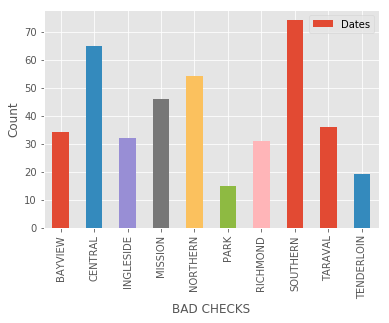

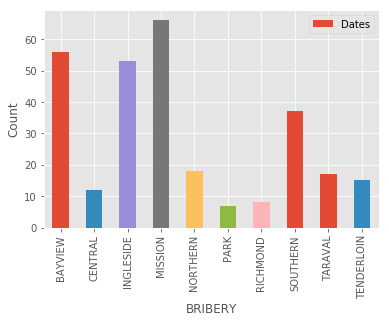

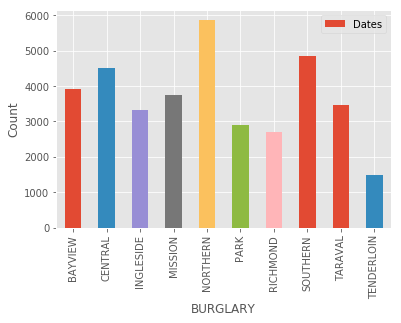

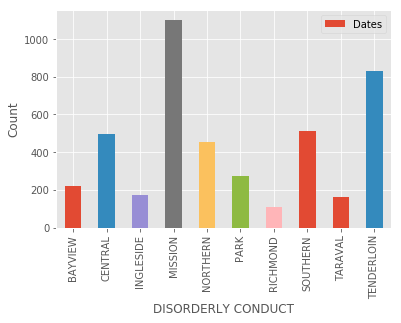

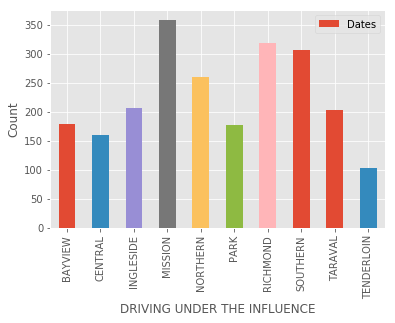

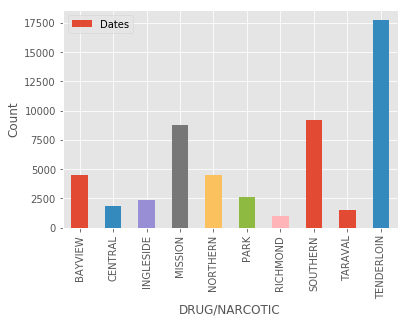

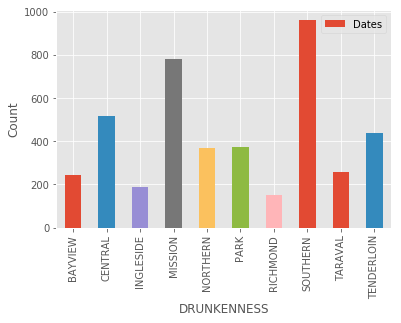

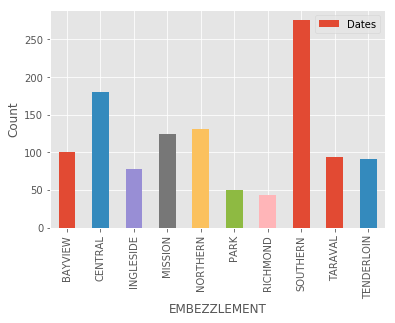

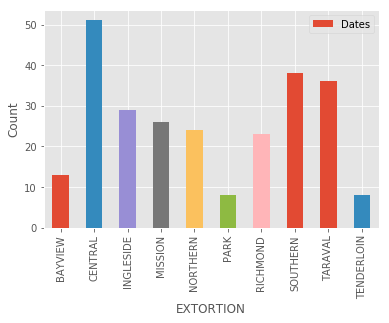

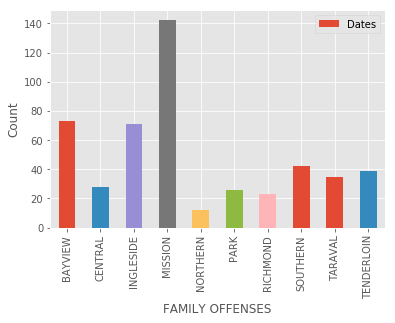

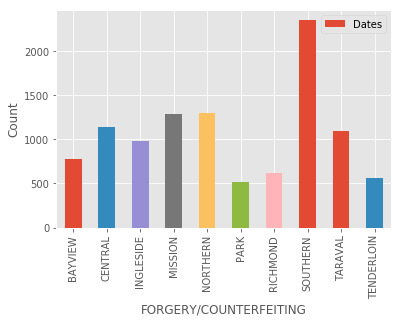

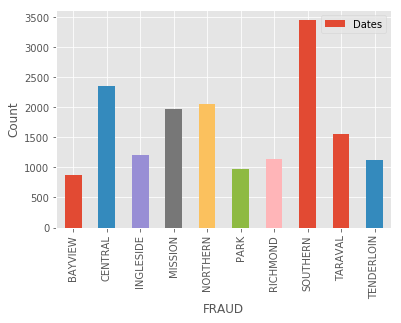

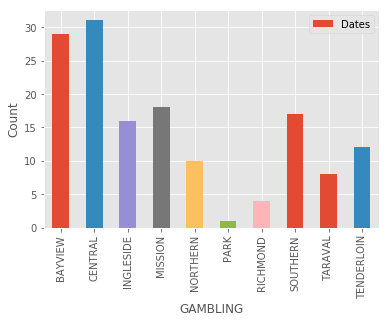

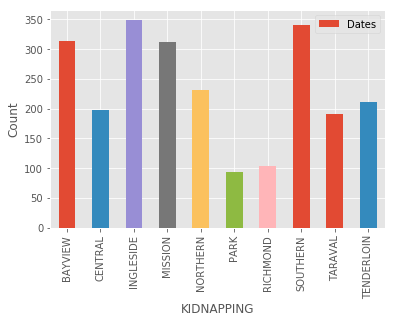

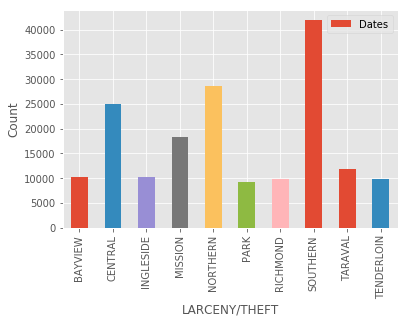

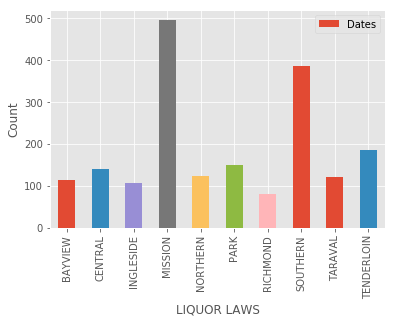

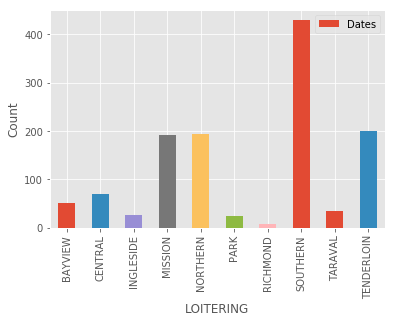

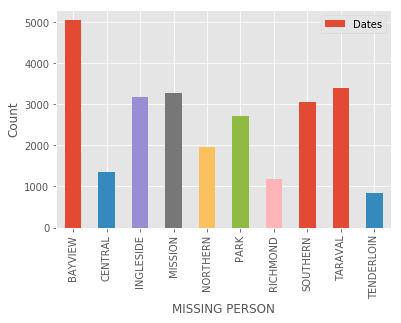

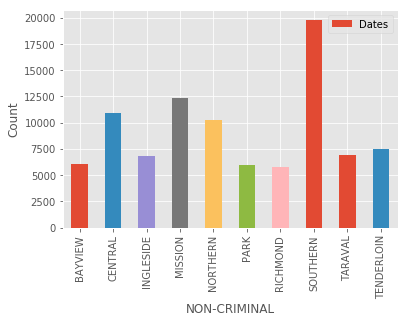

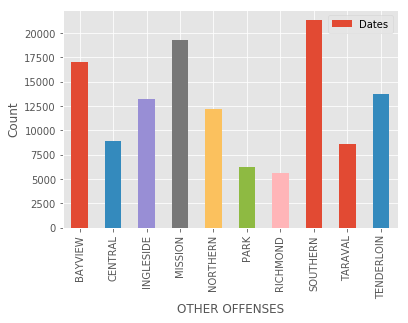

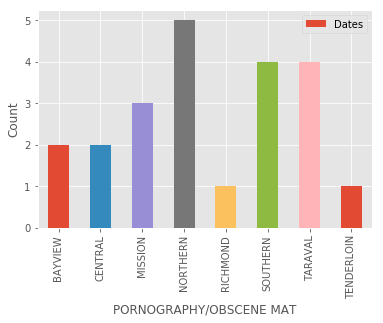

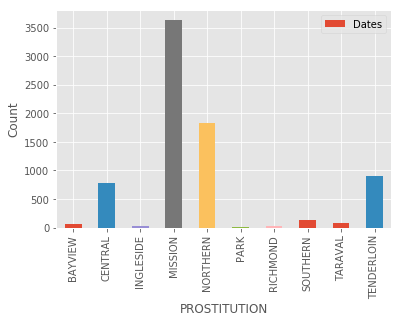

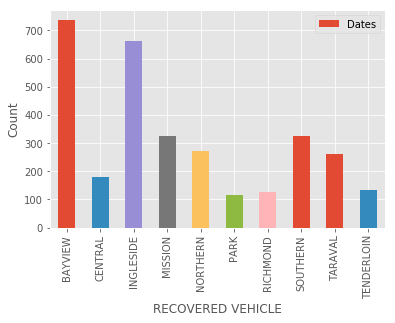

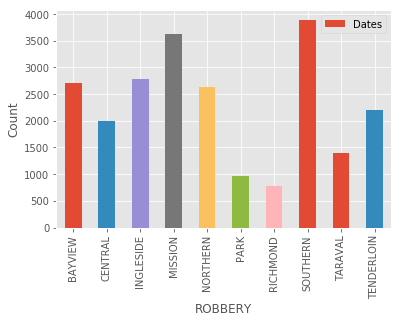

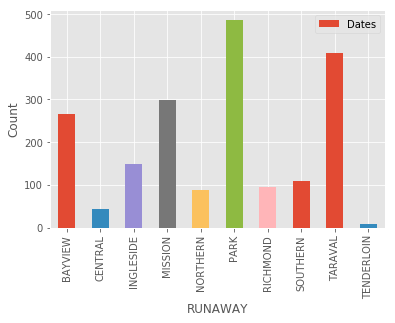

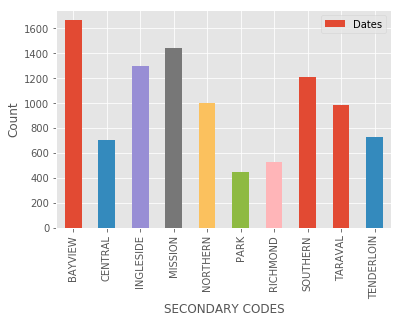

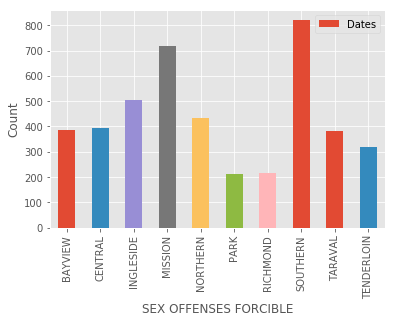

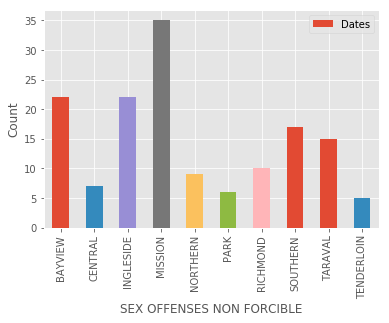

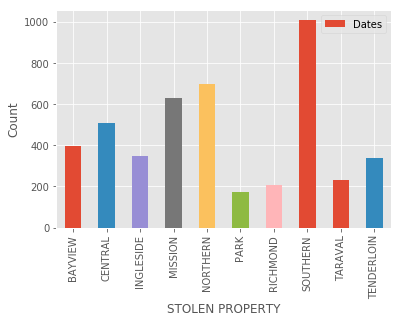

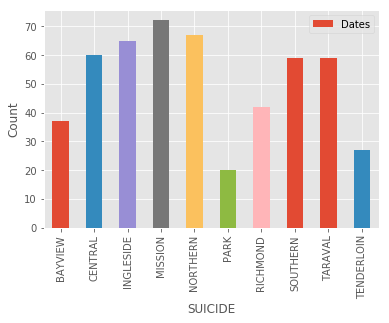

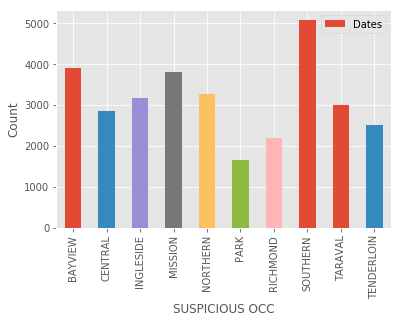

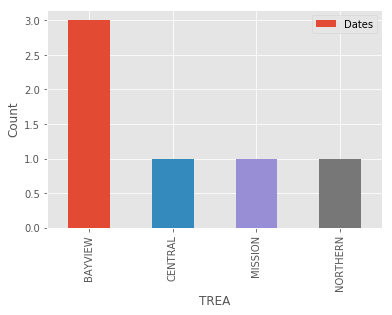

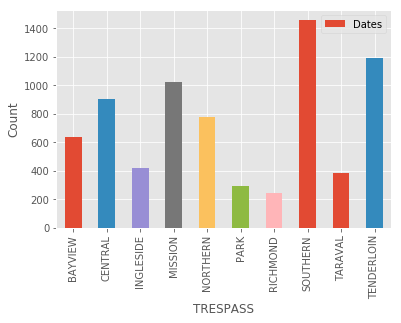

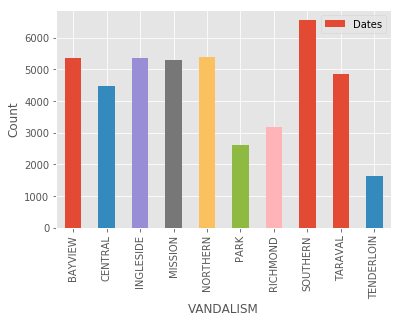

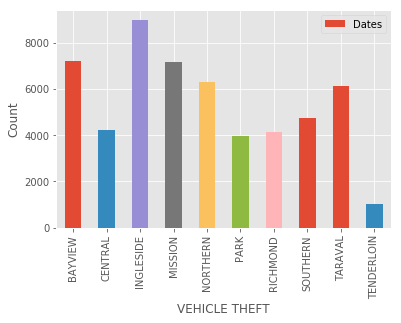

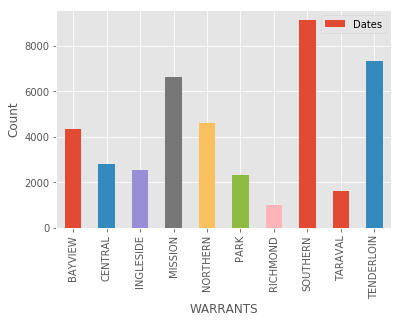

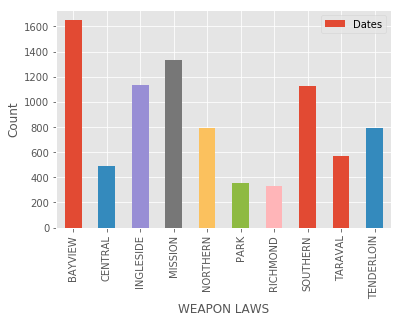

In [9]:
cpddist = train.groupby(['Category', 'PdDistrict']).count().reset_index()
for category in cpddist['Category'].unique():
    data = cpddist[cpddist['Category'] == category]
    data.plot.bar(x='PdDistrict', y='Dates') # doesn't matter which, just looking at count
    plt.xlabel(category)
    plt.ylabel('Count')

### Takeaways
- ARSON high for Bayview
- 

## Percentage of crime by pdDistrict

In [56]:
print(train.PdDistrict.unique())

['NORTHERN' 'PARK' 'INGLESIDE' 'BAYVIEW' 'RICHMOND' 'CENTRAL' 'TARAVAL'
 'TENDERLOIN' 'MISSION' 'SOUTHERN']


In [64]:
# adding a total column
perct = pd.crosstab([train.Category], train.PdDistrict).reset_index()
perct['total'] = perct.sum(axis=1)

# calculating percent for each row        
for district in train.PdDistrict.unique():
    perct[district+'%'] = perct.apply(lambda perct: perct[district]/perct.total*100, axis=1)

# dropping unncessary columns
perct = perct.drop(['BAYVIEW', 'CENTRAL', 'INGLESIDE', 'MISSION', 'NORTHERN', 'PARK', 'RICHMOND', 'SOUTHERN', 'TARAVAL', 'TENDERLOIN', 'total'], axis=1)
perct

PdDistrict,Category,NORTHERN%,PARK%,INGLESIDE%,BAYVIEW%,RICHMOND%,CENTRAL%,TARAVAL%,TENDERLOIN%,MISSION%,SOUTHERN%
0,ARSON,9.847984,4.296100,12.029081,25.974884,6.807667,7.336418,7.931262,3.965631,9.583609,12.227363
1,ASSAULT,10.820022,4.572298,11.099693,12.821947,4.165149,9.075654,7.106249,9.988813,14.502576,15.847599
2,BAD CHECKS,13.300493,3.694581,7.881773,8.374384,7.635468,16.009852,8.866995,4.679803,11.330049,18.226601
3,BRIBERY,6.228374,2.422145,18.339100,19.377163,2.768166,4.152249,5.882353,5.190311,22.837370,12.802768
4,BURGLARY,15.927085,7.857434,9.062713,10.692423,7.335056,12.294926,9.421847,4.048429,10.189090,13.170997
5,DISORDERLY CONDUCT,10.462963,6.273148,3.958333,5.069444,2.500000,11.435185,3.750000,19.282407,25.439815,11.828704
6,DRIVING UNDER THE INFLUENCE,11.463845,7.760141,9.082892,7.892416,14.065256,7.054674,8.906526,4.541446,15.740741,13.492063
7,DRUG/NARCOTIC,8.358192,4.767375,4.396806,8.334105,1.850994,3.344389,2.836709,32.787979,16.225380,17.098071
8,DRUNKENNESS,8.598131,8.738318,4.439252,5.677570,3.481308,12.079439,6.051402,10.257009,18.271028,22.406542
9,EMBEZZLEMENT,11.234991,4.288165,6.689537,8.576329,3.687822,15.437393,8.061750,7.804460,10.634648,23.584906


#### Takeaways
- 
- 
-

In [30]:
train[train['Category'] == 'PROSTITUTION'].groupby(['Category', 'PdDistrict']).count().reset_index().sort_values(by='Dates', ascending=False)

,Category,PdDistrict,Dates,Descript,DayOfWeek,Resolution,Address,X,Y
3,PROSTITUTION,MISSION,3629,3629,3629,3629,3629,3629,3629
4,PROSTITUTION,NORTHERN,1831,1831,1831,1831,1831,1831,1831
9,PROSTITUTION,TENDERLOIN,904,904,904,904,904,904,904
1,PROSTITUTION,CENTRAL,778,778,778,778,778,778,778
7,PROSTITUTION,SOUTHERN,135,135,135,135,135,135,135
8,PROSTITUTION,TARAVAL,82,82,82,82,82,82,82
0,PROSTITUTION,BAYVIEW,70,70,70,70,70,70,70
2,PROSTITUTION,INGLESIDE,26,26,26,26,26,26,26
6,PROSTITUTION,RICHMOND,24,24,24,24,24,24,24
5,PROSTITUTION,PARK,5,5,5,5,5,5,5


## Time Series  

In [16]:
train['day'] == train.dates.day
train.groupby('day').size().plot

KeyError: 'day'